## 1 - Imports

In [229]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    roc_curve
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import tree

In [230]:
df = pd.read_csv('../data/DENGBR25.csv')

df.describe()

C:\Users\marco\AppData\Local\Temp\ipykernel_34428\1755544911.py:1: DtypeWarning: Columns (22,44,45,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/DENGBR25.csv')


,TP_NOT,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,SEM_PRI,ANO_NASC,NU_IDADE_N,...,PLASMATICO,EVIDENCIA,PLAQ_MENOR,CON_FHD,COMPLICA,TP_SISTEMA,NDUPLIC_N,CS_FLXRET,FLXRECEBI,MIGRADO_W
count,1605624.0,1.605624e+06,1.605624e+06,1.605624e+06,1.605624e+06,1.557265e+06,1.605464e+06,1.605624e+06,1.601051e+06,1.605624e+06,...,0.0,0.0,0.0,0.0,0.0,1587307.0,4339.0,1.605624e+06,1.0,0.0
mean,2.0,2.025155e+05,2.024999e+03,3.607638e+01,3.632703e+05,1.458755e+03,4.088451e+06,2.025149e+05,1.988136e+03,4.025077e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,3.034652e-01,2.0,NaN
std,0.0,9.558214e+00,3.678015e-02,7.121180e+00,7.084692e+04,3.807356e+02,2.612719e+06,9.487917e+00,2.007280e+01,1.308771e+02,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4.597545e-01,NaN,NaN
min,2.0,2.025010e+05,2.024000e+03,1.100000e+01,1.100010e+05,1.331000e+03,1.700000e+01,2.025010e+05,1.900000e+03,6.000000e+00,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.000000e+00,2.0,NaN
25%,2.0,2.025090e+05,2.025000e+03,3.500000e+01,3.504000e+05,1.342000e+03,2.087219e+06,2.025080e+05,1.974000e+03,4.020000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.000000e+00,2.0,NaN
50%,2.0,2.025140e+05,2.025000e+03,3.500000e+01,3.534400e+05,1.354000e+03,2.746298e+06,2.025130e+05,1.990000e+03,4.035000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.000000e+00,2.0,NaN
75%,2.0,2.025190e+05,2.025000e+03,3.500000e+01,3.555400e+05,1.465000e+03,6.595421e+06,2.025190e+05,2.004000e+03,4.050000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.000000e+00,2.0,NaN
max,2.0,2.025470e+05,2.025000e+03,5.300000e+01,5.300100e+05,6.256000e+03,9.999949e+06,2.025470e+05,2.981000e+03,4.407000e+03,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.000000e+00,2.0,NaN


## 2 - Limpeza

In [231]:
symptoms = [
    "ARTRALGIA", "ARTRITE", "CEFALEIA", "CONJUNTVIT", "DOR_COSTAS",
    "DOR_RETRO", "EXANTEMA", "FEBRE", "LACO", "LEUCOPENIA", "MIALGIA",
    "NAUSEA", "PETEQUIA_N", "VOMITO"
]

deseases = [
    "ACIDO_PEPT", "AUTO_IMUNE", "DIABETES",
    "HEMATOLOG", "HEPATOPAT", "HIPERTENSA",
    "RENAL"
]

geral = [
    "CS_GESTANT",
    "CS_SEXO",
    "NU_IDADE_N",
    "DT_SIN_PRI",
    "HOSPITALIZ"
]


considered_columns = geral + symptoms + deseases

In [232]:
df = df[considered_columns].copy()

df[considered_columns].isna().any(axis=1).sum()
df = df.dropna(subset=considered_columns)

print(df.shape)

(1213180, 26)


In [233]:
# Remove as duplicatas
print(f"Total de linhas duplicadas: {df.duplicated().sum()}")
df = df.drop_duplicates()

Total de linhas duplicadas: 219314


In [234]:
# Remove as linhas onde a coluna HOSPITALIZ está vazia ou contém o valor 9
total_nulos = df['HOSPITALIZ'].isna().sum()
print(f"A coluna HOSPITALIZ possui {total_nulos} valores nulos.")

df = df.dropna(subset=['HOSPITALIZ'])
df = df[df['HOSPITALIZ'] != 9]

A coluna HOSPITALIZ possui 0 valores nulos.


In [235]:
df = df[df['CS_SEXO'] != 'I']

def gestante_bin(v):
    if v in [1, 2, 3, 4]:
        return 1.0   # gestante
    if v in [5, 6,9]:
        return 0.0   # não gestante

df["CS_GESTANT"] = df["CS_GESTANT"].apply(gestante_bin)

Criação de variáveis binárias para facilitar a análise. 
- A variável de hospitalização será convertida para formato binário onde 1 indica hospitalização e 0 indica não hospitalização.
- Variáveis clínicas para formato binário, onde 1 representa presença do sintoma/comorbidade e 0 representa ausência.

In [236]:
def sinan_bin(s):
    x = pd.to_numeric(s, errors="coerce")
    return x.map({1: 1.0, 2: 0.0})

variables = symptoms + deseases
df[variables] = df[variables].apply(sinan_bin)
df["HOSPITALIZ"] = sinan_bin(df["HOSPITALIZ"])

Conversão da variável de idade do formato SINAN para anos. O campo NU_IDADE_N armazena idade codificada onde os primeiros dígitos indicam a unidade (horas, dias, meses ou anos).

In [237]:
# valores a baixo de 1000 podem ser erro de digitação
# print(df['NU_IDADE_N'].value_counts().sort_index())
df = df[df['NU_IDADE_N'] >= 1000]
df = df[df['NU_IDADE_N'] // 1000 <= 4]


def age_years(nu_age):
    if pd.isna(nu_age):
        return np.nan

    try:
        nu_age = int(nu_age)
    except:
        return np.nan

    unidade = nu_age // 1000
    valor   = nu_age % 1000

    if unidade == 1:      # horas
        return valor / (24 * 365)
    elif unidade == 2:    # dias
        return valor / 365
    elif unidade == 3:    # meses
        return valor / 12
    elif unidade == 4:    # anos
        return valor
    else:
        return np.nan

df["AGE_YEARS"] = df["NU_IDADE_N"].apply(age_years)

bins = [0, 5, 15, 30, 50, 65, 120]
labels = ["0-4","5-14","15-29","30-49","50-64","65+"]

df["AGE_RANGE"] = pd.cut(df["AGE_YEARS"], bins=bins, labels=labels)

df = df.dropna(subset=['AGE_RANGE'])

## 3 - Análise gráfica de fatores associados a hospitalização


### 3.1 Visualização Geral de Hospitalizações

Grafico para mostrar proporção de casos hospitalizados vs total de casos notificados.

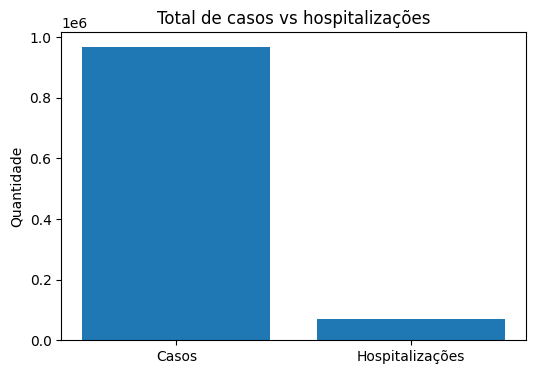

In [238]:
total_ocurrences = df["HOSPITALIZ"].notna().sum()
total_hospitalized = df["HOSPITALIZ"].sum()

labels = ["Casos", "Hospitalizações"]
values = [total_ocurrences, total_hospitalized]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel("Quantidade")
plt.title("Total de casos vs hospitalizações")
plt.show()

### 3.2 Impacto de Sintomas e Comorbidades

Análise do impacto cada sintoma e comorbidade na taxa de hospitalização. O objetivo é identificar quais variáveis clínicas estão associadas com casos graves que necessitam hospitalização.

Cálculo da diferença na taxa de hospitalização entre pacientes com e sem cada sintoma/comorbidade.

**Como interpretar**: Valores positivos indicam que a presença do sintoma/doença aumenta a probabilidade de hospitalização. A diferença é medida em **pontos percentuais (pp)**.

**Exemplo prático**: Se 5% dos pacientes sem diabetes são hospitalizados e 15% dos pacientes com diabetes são hospitalizados, a diferença é de +10 pontos percentuais. Isso significa que ter diabetes está associado a um aumento de 10 pontos percentuais na taxa de hospitalização.

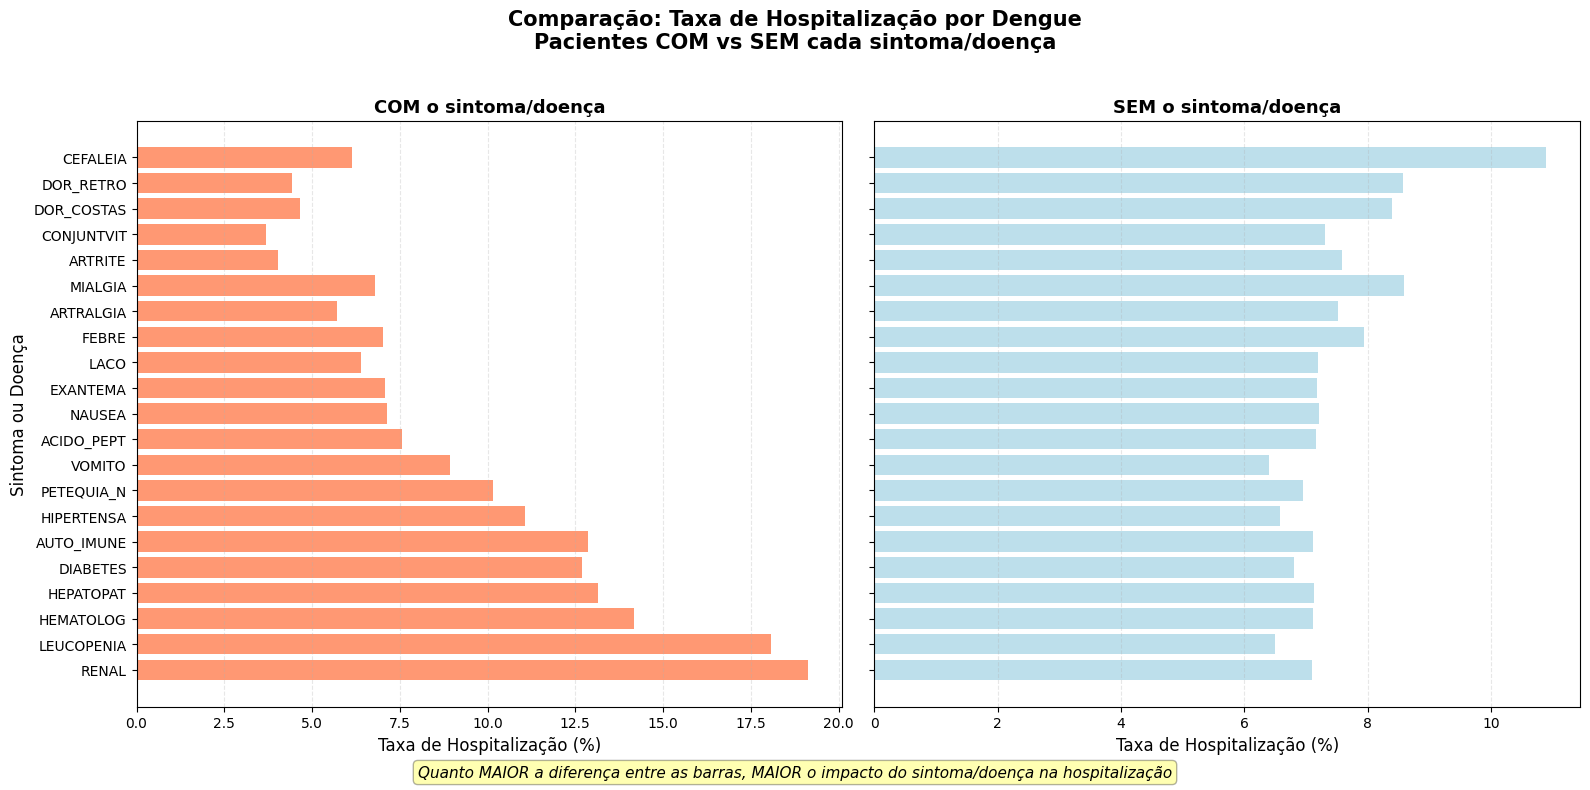

In [239]:
rates = []

for col in variables:
    tmp = pd.concat([df[col], df["HOSPITALIZ"]], axis=1).dropna()

    grp = tmp.groupby(col)["HOSPITALIZ"].mean()

    hosp_rate_no  = grp.get(0.0, np.nan)
    hosp_rate_yes = grp.get(1.0, np.nan)

    rates.append({
        "symptom": col,
        "hosp_rate_no": hosp_rate_no,
        "hosp_rate_yes": hosp_rate_yes,
        "delta_pp": (hosp_rate_yes - hosp_rate_no) * 100
    })

rates_df = pd.DataFrame(rates).sort_values("delta_pp", ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.barh(rates_df["symptom"], rates_df["hosp_rate_yes"] * 100, color='coral', alpha=0.8)
ax1.set_xlabel("Taxa de Hospitalização (%)", fontsize=12)
ax1.set_ylabel("Sintoma ou Doença", fontsize=12)
ax1.set_title("COM o sintoma/doença", fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')

ax2.barh(rates_df["symptom"], rates_df["hosp_rate_no"] * 100, color='lightblue', alpha=0.8)
ax2.set_xlabel("Taxa de Hospitalização (%)", fontsize=12)
ax2.set_title("SEM o sintoma/doença", fontsize=13, fontweight='bold')
ax2.set_yticklabels([])  # Remove labels duplicados
ax2.grid(axis='x', alpha=0.3, linestyle='--')

fig.suptitle('Comparação: Taxa de Hospitalização por Dengue\nPacientes COM vs SEM cada sintoma/doença',
             fontsize=15, fontweight='bold', y=0.98)

fig.text(0.5, 0.02,
         'Quanto MAIOR a diferença entre as barras, MAIOR o impacto do sintoma/doença na hospitalização',
         ha='center', fontsize=11, style='italic',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### 3.3 Análise por Faixa Etária e Doença

Investigação da relação entre idade, presença de doença(diabetes) e risco de hospitalização.
 A idade é uma variável importante em dengue, especialmente quando combinada com comorbidades como diabetes.


C:\Users\marco\AppData\Local\Temp\ipykernel_34428\225671154.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["AGE_RANGE", "DIABETES"])["HOSPITALIZ"]


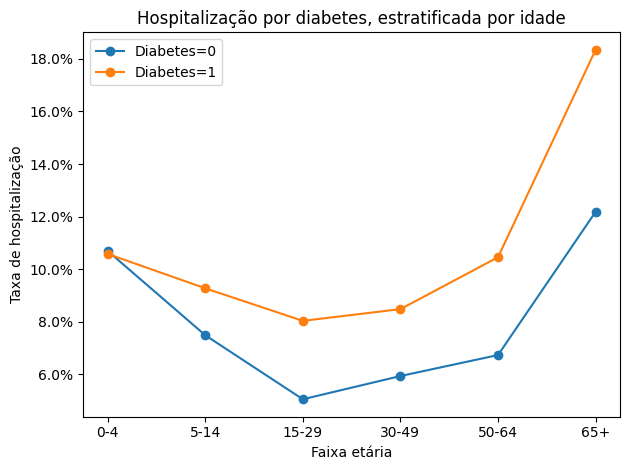

In [240]:
tmp = pd.concat([
    df["DIABETES"],
    df["HOSPITALIZ"],
    df["AGE_RANGE"]
], axis=1).dropna()

rate_age = (
    tmp
    .groupby(["AGE_RANGE", "DIABETES"])["HOSPITALIZ"]
    .mean()
    .reset_index()
)
rate_age

for v in [0.0, 1.0]:
    sub = rate_age[rate_age["DIABETES"] == v]
    plt.plot(sub["AGE_RANGE"], sub["HOSPITALIZ"], marker="o", label=f"Diabetes={int(v)}")

plt.ylabel("Taxa de hospitalização")
plt.xlabel("Faixa etária")
plt.title("Hospitalização por diabetes, estratificada por idade")

plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

### 3.4 Sazonalidade da Hospitalização

Análise temporal para identificar padrões sazonais na taxa de hospitalização.

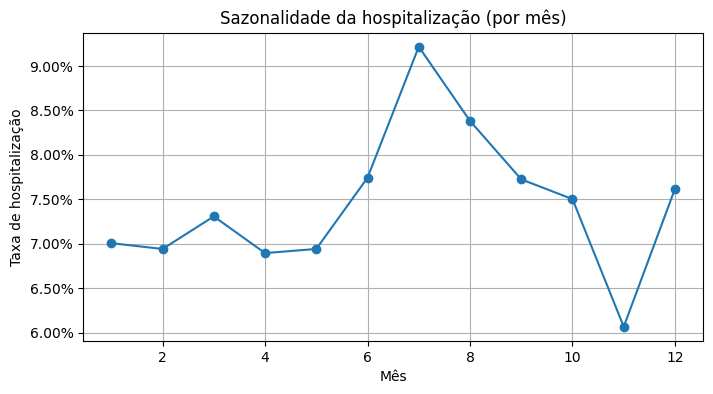

In [241]:
dt_sint = pd.to_datetime(df["DT_SIN_PRI"], errors="coerce")
dt_mes = dt_sint.dt.month

tmp = pd.concat([df["HOSPITALIZ"], dt_mes.rename("MES")], axis=1).dropna()

rate_month = (
    tmp
    .groupby("MES")["HOSPITALIZ"]
    .mean()
)

plt.figure(figsize=(8,4))
rate_month.plot(marker="o")
plt.xlabel("Mês")
plt.ylabel("Taxa de hospitalização")
plt.title("Sazonalidade da hospitalização (por mês)")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True)
plt.show()

### 3.5 Fatores de Risco Específicos

Comparação da taxa de hospitalização entre gestantes e não gestantes. A gravidez é um fator de risco conhecido para complicações de dengue.

            HOSPITALIZ
CS_GESTANT            
0.0           0.067446
1.0           0.136163


<Figure size 800x500 with 0 Axes>

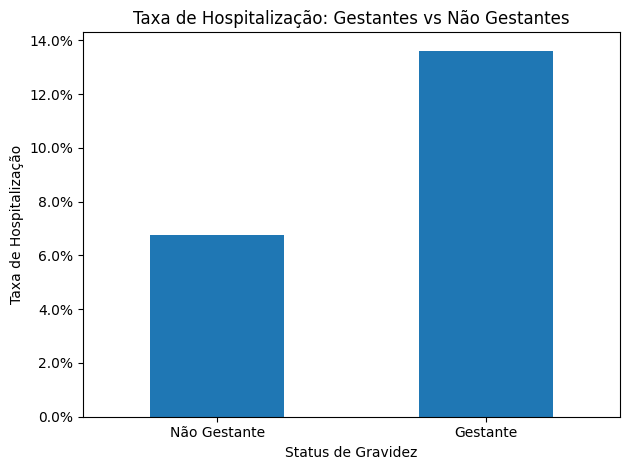

In [242]:
df_f = df[df["CS_SEXO"].eq("F")].copy()

tmp = pd.concat([df["CS_GESTANT"], df["HOSPITALIZ"].loc[df_f.index]], axis=1).dropna()

resultado_gestantes = tmp.groupby("CS_GESTANT").mean()
print(resultado_gestantes)

# Gráfico de barras para gestantes
plt.figure(figsize=(8, 5))
resultado_gestantes.plot(kind='bar', legend=False)
plt.xlabel("Status de Gravidez")
plt.ylabel("Taxa de Hospitalização")
plt.title("Taxa de Hospitalização: Gestantes vs Não Gestantes")
plt.xticks([0, 1], ['Não Gestante', 'Gestante'], rotation=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

### 3.6 Distribuição de Casos por Faixa Etária

Visualização da quantidade de casos em cada faixa etária para identificar os grupos mais afetados.

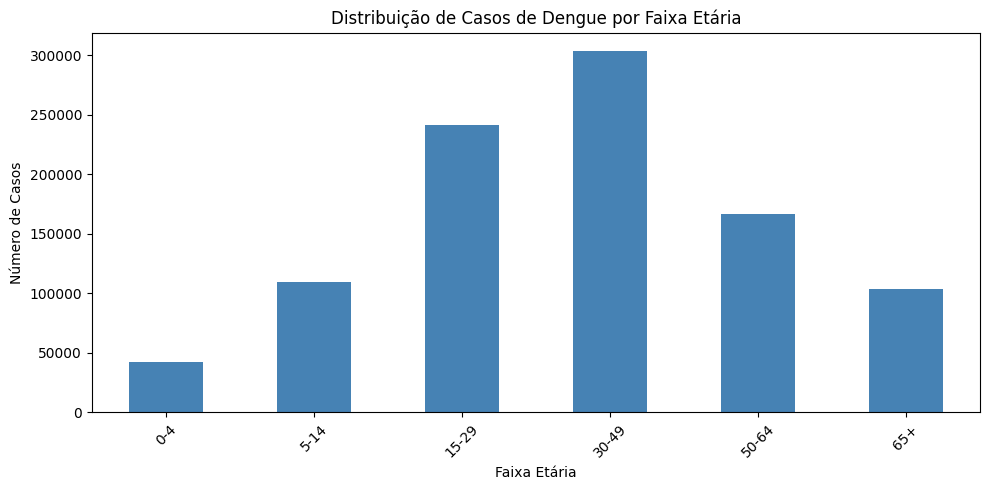

In [243]:
# Distribuição por faixa etária
faixa_counts = df["AGE_RANGE"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
faixa_counts.plot(kind='bar', color='steelblue')
plt.xlabel("Faixa Etária")
plt.ylabel("Número de Casos")
plt.title("Distribuição de Casos de Dengue por Faixa Etária")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.7 Correlação entre Sintomas

Mapa de calor mostrando a correlação entre diferentes sintomas. Valores próximos a 1 indicam que os sintomas tendem a aparecer juntos.

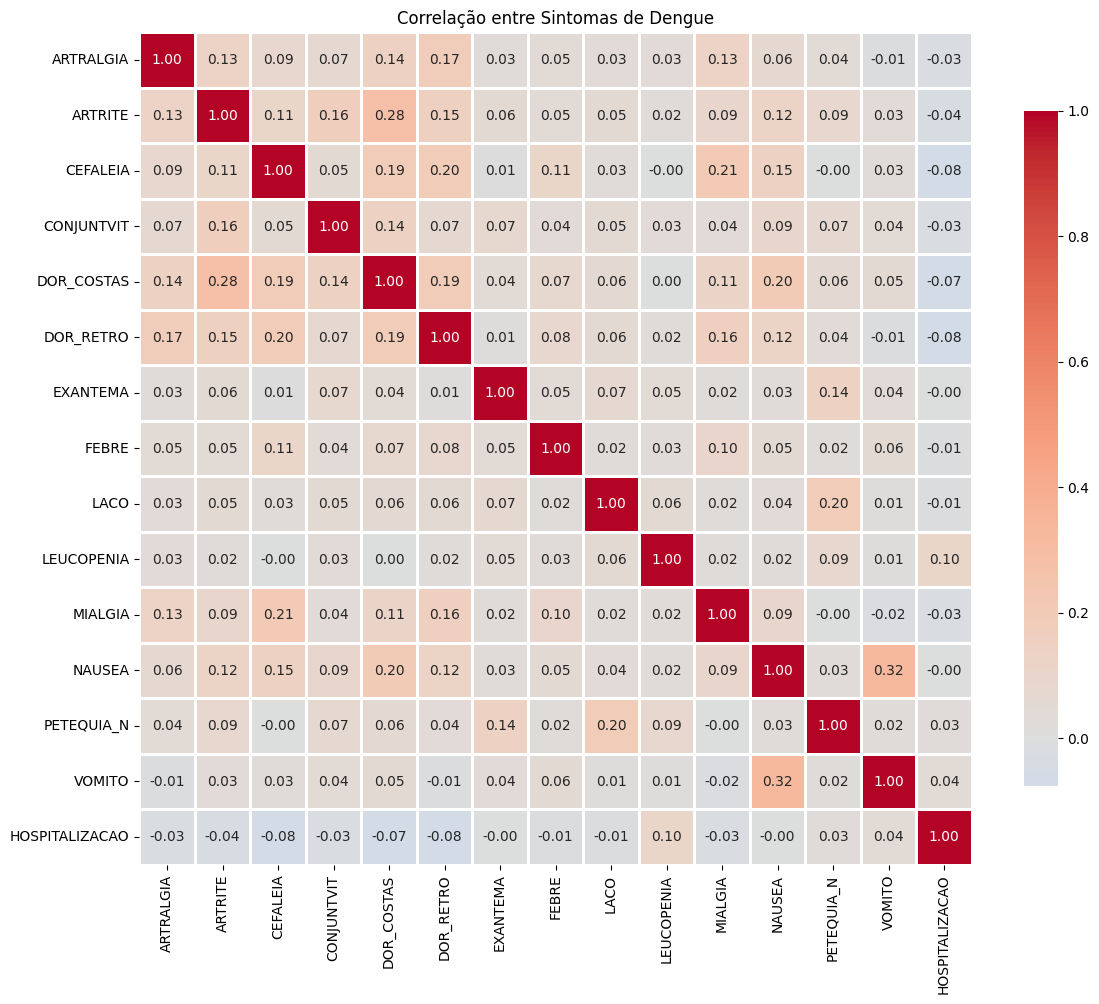

In [244]:
# Heatmap de correlação entre sintomas
# Cria um DataFrame com sintomas e hospitalização para correlação
symptoms_with_hosp = df[symptoms].copy()
symptoms_with_hosp["HOSPITALIZACAO"] = df["HOSPITALIZ"]
correlacao = symptoms_with_hosp.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlacao, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlação entre Sintomas de Dengue")
plt.tight_layout()
plt.show()

## 4 - Preparação para ML

In [245]:
print(df["HOSPITALIZ"].value_counts())

HOSPITALIZ
0.0    898108
1.0     69321
Name: count, dtype: int64


Identifica quais colunas são do tipo texto

In [246]:
colunas_texto = df.select_dtypes(include=['object']).columns.tolist()

print(f"Colunas que precisam de conversão: {colunas_texto}")

Colunas que precisam de conversão: ['CS_SEXO', 'DT_SIN_PRI']


Label encoder para coluna CS_SEXO

In [247]:
le = LabelEncoder()

df['CS_SEXO'] = le.fit_transform(df['CS_SEXO'])

Ajustes para colunas no formato de data

In [248]:
# Garante que a coluna está no formato de data
df['DT_SIN_PRI'] = pd.to_datetime(df['DT_SIN_PRI'])

# Extrai os componentes numéricos
df['ANO_SIN'] = df['DT_SIN_PRI'].dt.year
df['MES_SIN'] = df['DT_SIN_PRI'].dt.month
df['DIA_SIN'] = df['DT_SIN_PRI'].dt.day
df['DIA_SEMANA_SIN'] = df['DT_SIN_PRI'].dt.dayofweek # 0=Segunda, 6=Domingo

# Agora que temos os números, removemos a coluna original de data
df = df.drop('DT_SIN_PRI', axis=1)
df = df.drop('AGE_RANGE', axis=1)

Se der algo como 95% para 0 e 5% para 1, está desbalanceado.

In [249]:
print(df['HOSPITALIZ'].value_counts(normalize=True))

HOSPITALIZ
0.0    0.928345
1.0    0.071655
Name: proportion, dtype: float64


Função para preparar os dataframes para os modelos, no caso, normalizando e balanceado o dataframe.

In [250]:
def preparar_dados(df, target_col):
    # 1. Separar X e y
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # 2. Divisão Treino e Teste (80/20)
    # O stratify é vital aqui para manter a proporção da hospitalização
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 3. Normalização (Fit apenas no treino para evitar Leakage)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4. Balanceamento (SMOTE) apenas no treino
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

    return X_train_res, X_test_scaled, y_train_res, y_test

In [251]:
# Dados tratados para o uso no modelos
df = df.sample(n=10000, random_state=42)
X_train_res, X_test_scaled, y_train_res, y_test = preparar_dados(df, 'HOSPITALIZ')

## 5 - Modelos

### 5.1 RANDOM FOREST


===== RANDOM FOREST =====

Accuracy: 0.6895
Balanced Accuracy: 0.590467646388699
Score treino: 0.7835114297308264
Score teste: 0.6895


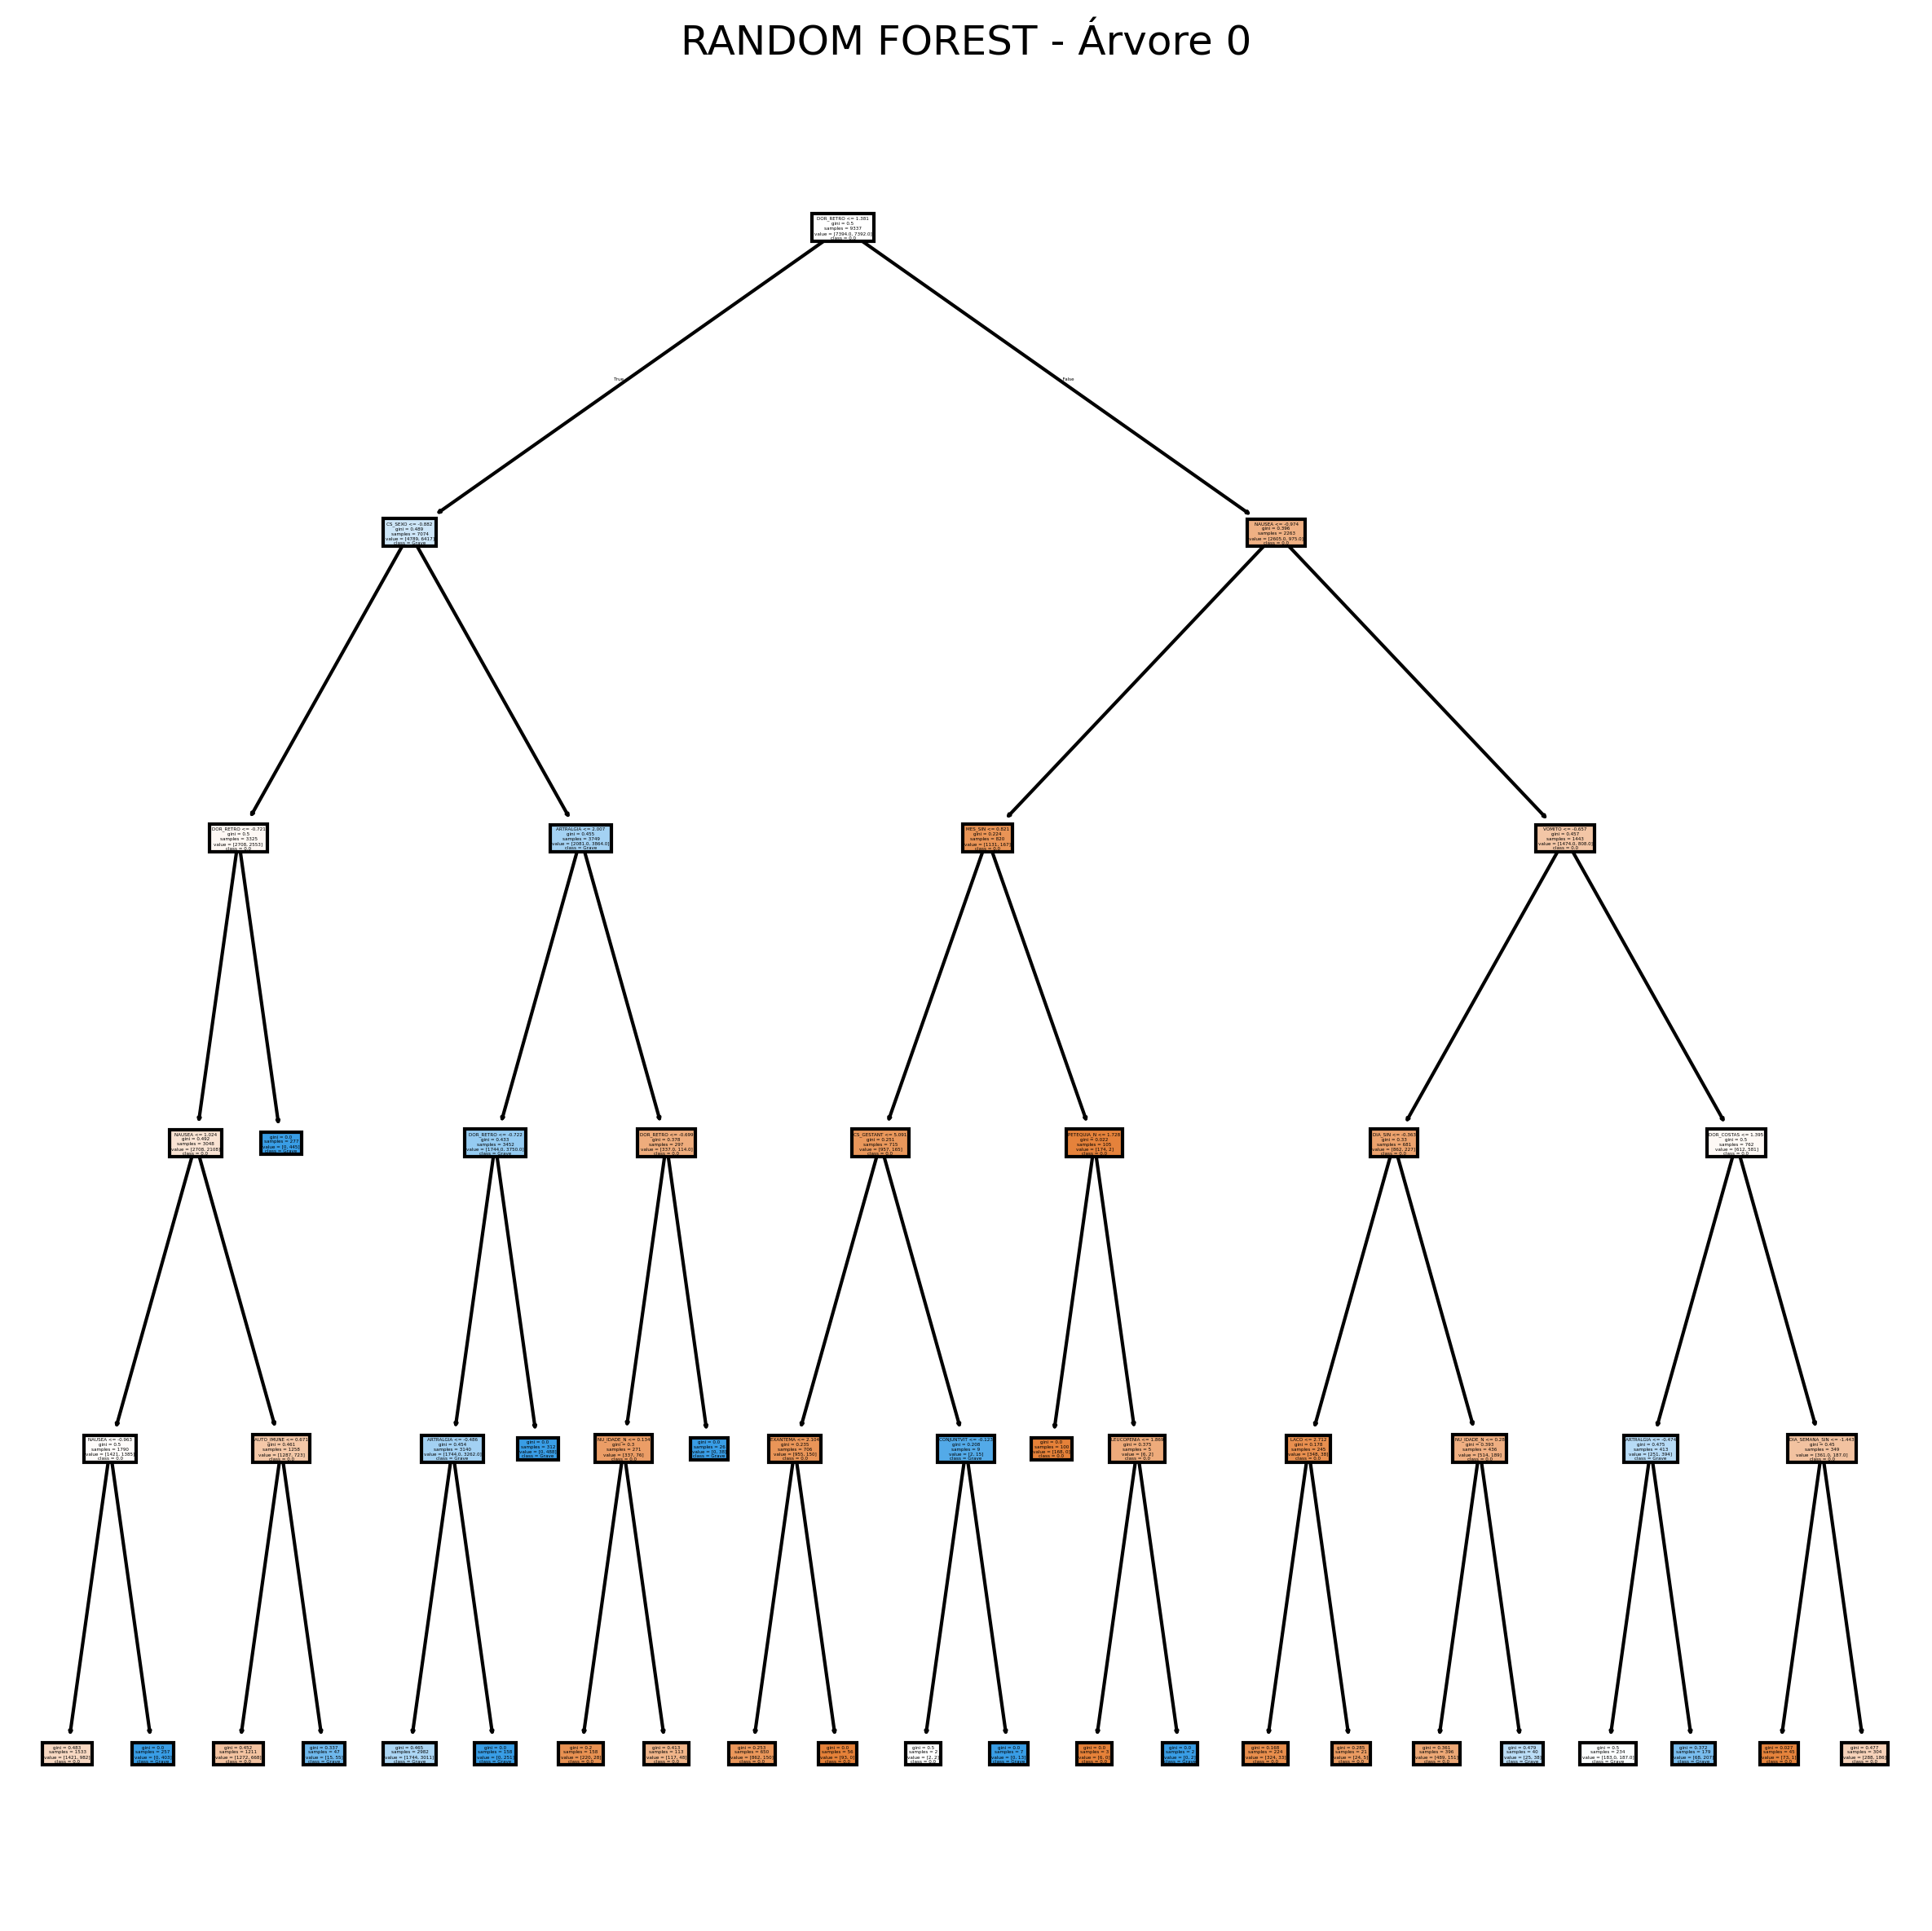

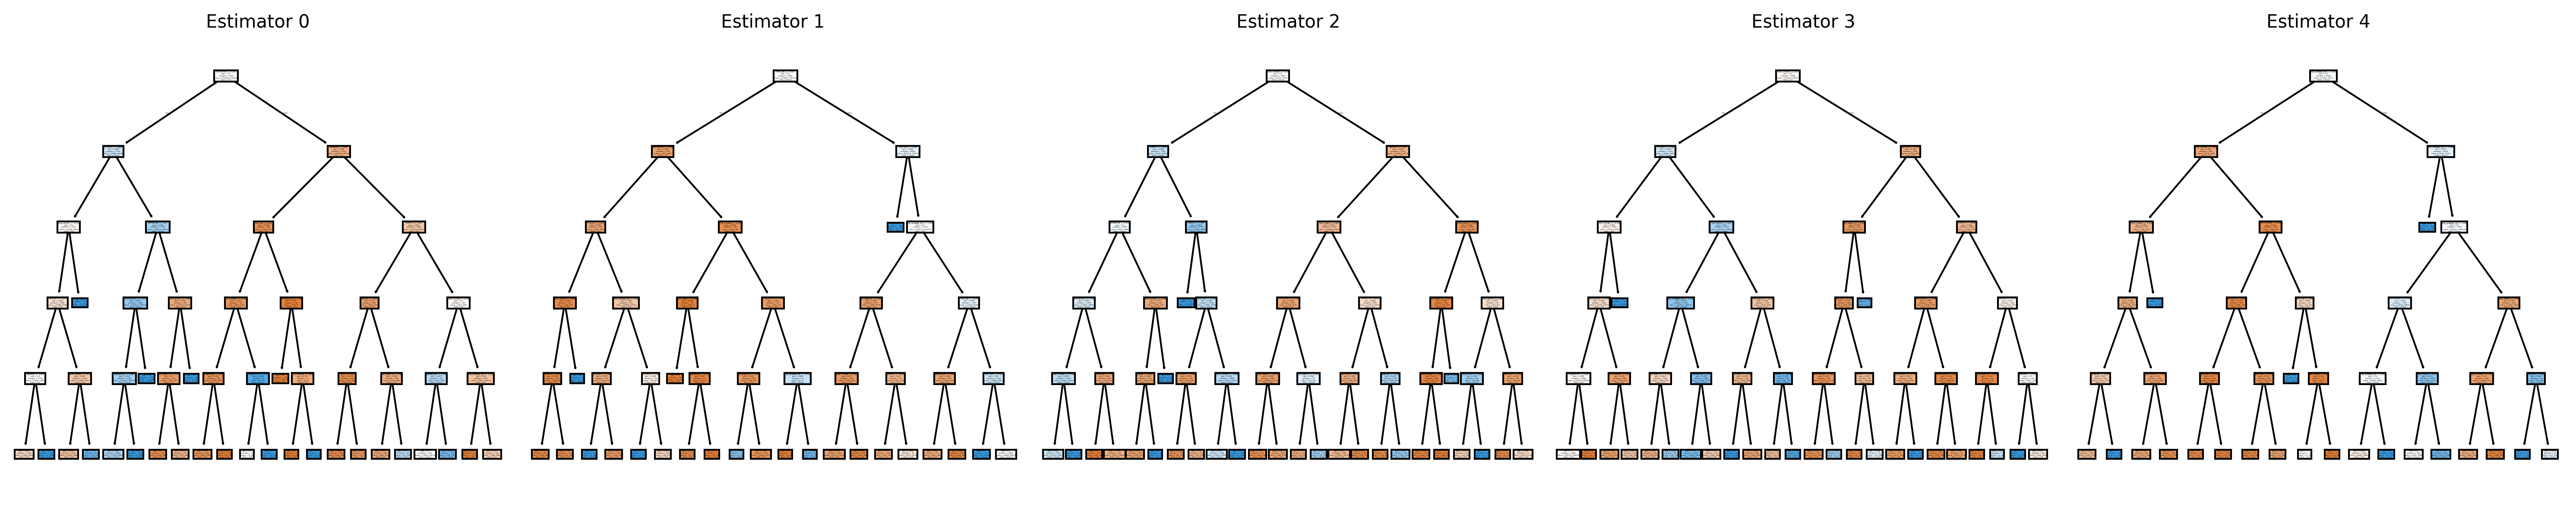

In [252]:
# FUNÇÃO: treinar e plotar RF com dados já preparados
def treinar_e_plotar_rf_df(
    X_train_res, X_test_scaled, y_train_res, y_test,
    feature_names,
    nome,
    n_estimators=50,
    max_depth=5,
    n_plot=5,
    random_state=42,
    min_samples_leaf=2,
    min_samples_split=5,
    max_features="sqrt"
):
    # SMOTE já balanceou, não usamos class_weight
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=random_state,
        n_jobs=-1
    )

    rf.fit(X_train_res, y_train_res)
    y_pred = rf.predict(X_test_scaled)

    print(f"\n===== {nome} =====")

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

    print("Score treino:", rf.score(X_train_res, y_train_res))
    print("Score teste:", rf.score(X_test_scaled, y_test))


    class_map = {1.0: "Grave", 2.0: "Não grave"}
    class_names = [class_map.get(c, str(c)) for c in rf.classes_]

    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    tree.plot_tree(
        rf.estimators_[0],
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        ax=ax
    )
    ax.set_title(f"{nome} - Árvore 0")
    fig.tight_layout()
    fig.savefig(f"{nome}_arvore0.png")
    plt.show()

 
    n_plot = min(n_plot, len(rf.estimators_))
    fig, axes = plt.subplots(1, n_plot, figsize=(4*n_plot, 4), dpi=300)
    if n_plot == 1:
        axes = [axes]

    for i in range(n_plot):
        tree.plot_tree(
            rf.estimators_[i],
            feature_names=feature_names,
            class_names=class_names,
            filled=True,
            ax=axes[i]
        )
        axes[i].set_title(f"Estimator {i}", fontsize=10)

    fig.tight_layout()
    fig.savefig(f"{nome}_{n_plot}arvores.png")
    plt.show()

    # Retorna modelo + teste (para ROC depois)
    return rf, X_test_scaled, y_test


X_train_convert, X_test_convert, y_train_convert, y_test_convert = preparar_dados(
    df, "HOSPITALIZ"
)

feature_names_convert = list(
    df.drop(columns=["HOSPITALIZ"]).columns
)

rf_convertido, X_test_convert, y_test_convert = treinar_e_plotar_rf_df(
    X_train_convert, X_test_convert, y_train_convert, y_test_convert,
    feature_names_convert,
    nome="RANDOM FOREST",
    n_estimators=50,
    max_depth=5,
    n_plot=5
)

ROC AUC: 0.6415844298245614


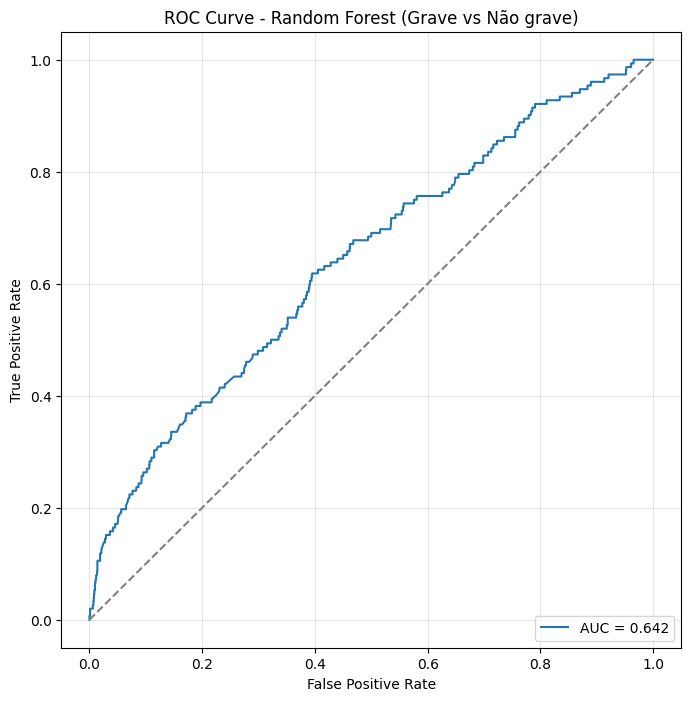

In [253]:
# índice da classe "Grave" (1.0)
idx_grave = list(rf_convertido.classes_).index(1.0)

# probabilidade da classe Grave
y_prob = rf_convertido.predict_proba(X_test_convert)[:, idx_grave]

# curva ROC 
fpr, tpr, thresholds = roc_curve(y_test_convert, y_prob, pos_label=1.0)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)

# plot
plt.figure(figsize=(8, 8))
plt.title("ROC Curve - Random Forest (Grave vs Não grave)")
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


### 5.2 K-Nearest Neighbors (KNN)

ENCONTRAR O MELHOR K

Testando diferentes valores de k...



Text(0, 0.5, 'Erro médio')

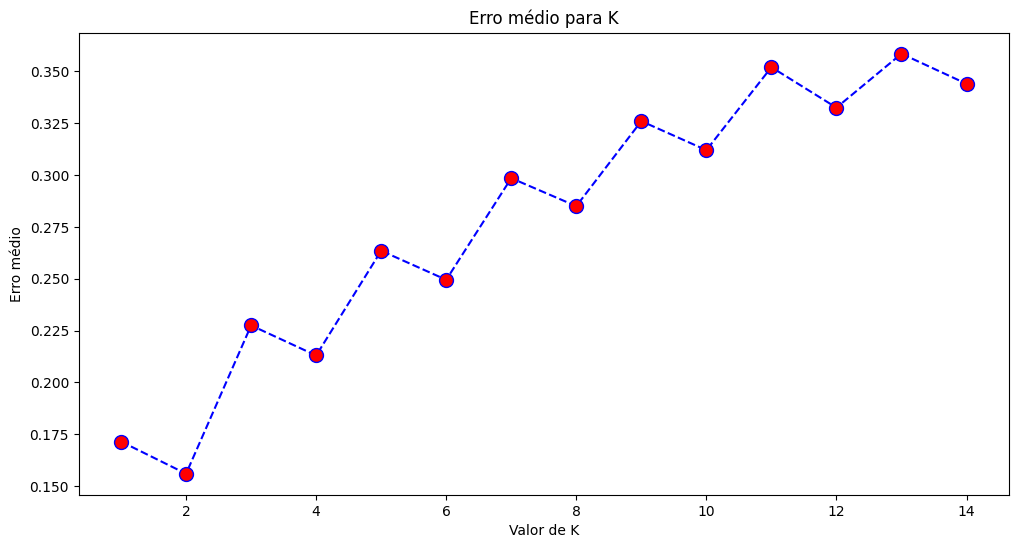

In [254]:
print('Testando diferentes valores de k...\n')
error = []

for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_res, y_train_res)
    pred_k = knn.predict(X_test_scaled)
    error.append(np.mean(pred_k != y_test))

plt.figure(figsize=(12,6))
plt.plot(range(1,15), error, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)

plt.title('Erro médio para K')
plt.xlabel('Valor de K')
plt.ylabel('Erro médio')

Buscar os melhores parâmetros

In [ ]:
param_grid = {'n_neighbors':[2,3,4], #total de vizinhos
              'weights': ['uniform', 'distance'], #Função de peso usada na previsão
              'metric':['cosine', 'euclidean', 'manhattan'] #métrica para cálculo da distância
             }

# Métrica de desempenho = melhor acurácia
gs_metric = make_scorer(accuracy_score, greater_is_better=True)

grid = GridSearchCV(KNeighborsClassifier(), 
                    param_grid=param_grid,
                    scoring=gs_metric,
                    cv=5, n_jobs=4, verbose=3) #cv = gerador de validação cruzada / n_jobs = determina a quantidade de jobs processados

grid.fit(X_train_res, y_train_res) #Selecionando os melhores hiperparametros com base nos dados de treino
knn_params = grid.best_params_
print('KNN', knn_params)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
KNN {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}


Treinar o modelo final com os melhores parâmetros

In [256]:
# TREINAR MODELO FINAL COM MELHOR K
knn_final = KNeighborsClassifier(
    n_neighbors=2, #best_k, 
    metric='manhattan', 
    weights='uniform',  # Pesa vizinhos mais próximos
    n_jobs=-1  # Usar todos os núcleos disponíveis
)

knn_final.fit(X_train_res, y_train_res)

# FAZER PREDIÇÕES
y_pred = knn_final.predict(X_test_scaled)

# METRICAS
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'\n RESULTADOS DO KNN')
print(f'=' * 40)
print(f'k: {2}')
print(f'Acurácia: {accuracy:.4f}')
print(f'F1-Score (weighted): {f1:.4f}')
print(f'=' * 40)


 RESULTADOS DO KNN
k: 2
Acurácia: 0.8650
F1-Score (weighted): 0.8658
